# Variational Autoencoders
## Generating images with a classical autoencoder

Can we use the autoencoder to generate new images?

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns

In [39]:
def plot_image_grid(image_array, image_size=2):
    # Determine the grid dimensions
    rows = len(image_array)          # Number of rows in the 2D array
    cols = len(image_array[0])       # Number of columns in the 2D array

    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * image_size, rows * image_size))

    # Flatten the axes array for easy iteration (in case it's 1D or 2D)
    # axes = axes.flatten() if rows > 1 and cols > 1 else [axes]

    # Iterate through the 2D array of images and plot them
    for i in range(rows):
        for j in range(cols):
            img = image_array[i][j] 
            if rows > 1:
                ax = axes[i][j]
            else:
                ax = axes[j]
            # Plot the image on the corresponding axis
            ax.imshow(img, cmap='gray')  # Use 'cmap' for grayscale images
            ax.axis('off')  # Turn off axis labels for a cleaner look

    # Adjust spacing between subplots to minimize wasted space
    plt.tight_layout(pad=0.5)

    # Show the plot
    plt.show()

def plot_images(images, num_cols, figsize=(10, 10), cmap='gray'):   
    # Determine the number of rows needed
    num_images = len(images)
    num_rows = int(np.ceil(num_images / num_cols))  # Ceiling division

    # Create a figure and axes grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Flatten the axes array if it's multidimensional (for easy iteration)
    if num_rows > 1 and num_cols > 1:
        axes = axes.flatten()
    else:
        axes = axes  # Handle single row or single column case

    # Plot each image
    for i, ax in enumerate(axes):
        if i < num_images:  # Only plot if there's an image
            ax.imshow(images[i], cmap=cmap)
            ax.axis('off')  # Turn off axis for cleaner look
        else:
            ax.axis('off')  # Hide unused axes

    # Adjust spacing between subplots
    plt.tight_layout(pad=0.5)

    # Show the plot
    plt.show()

def to_image(t):
    return t.cpu().squeeze(0).numpy()

def interpolate_vectors(a, b, N):
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a, dtype=torch.float32)
    else:
        a = a.clone().detach().to(torch.float32)

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b, dtype=torch.float32)
    else:
        b = b.clone().detach().to(torch.float32)

    # Generate interpolation weights (N+1 values between 0 and 1)
    t = torch.linspace(0, 1, N + 1).unsqueeze(1)  # Shape: (N+1, 1)

    # Perform linear interpolation
    interpolated_vectors = (1 - t) * a + t * b  # Shape: (N+1, d)

    return interpolated_vectors

def get_gpu_temperature():
    try:
        result = subprocess.run(["nvidia-smi", "--query-gpu=temperature.gpu", "--format=csv,noheader,nounits"],
                                stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
        if result.returncode == 0:
            temperature = int(result.stdout.strip())
            return temperature
        else:
            print("Error running nvidia-smi:")
            print(result.stderr)
            return None
    except Exception as e:
        print("An error occurred:", str(e))
        return None

Lets use the autoencoder trained before

In [40]:
# Define the Auto-Encoder model
class ConvAutoEncoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(ConvAutoEncoder, self).__init__()
        # Encoder: Reduces image to latent representation
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, latent_dim),  # Latent representation
        )
        # Decoder: Reconstructs image from latent representation
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()  # Output pixel values in range [0, 1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed



In [68]:
model = ConvAutoEncoder(2)
model.load_state_dict(torch.load('models/conv_autoencoder_2.pth'))

<All keys matched successfully>

In [69]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

What is the distribution of vectors created by the encoder?

In [70]:
coords = []
digits = []
for image, digit in dataloader:
    with torch.no_grad():
        coord = model.encoder(image)
        coords.append(coord)
    digits.append(digit)

In [71]:
all_coords = torch.cat(coords, dim=0)
all_digits = torch.cat(digits, dim=0)
all_coords.shape, all_digits.shape

(torch.Size([60000, 2]), torch.Size([60000]))

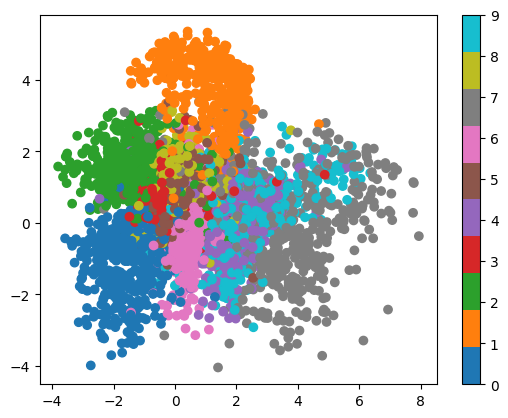

In [72]:
scatter = plt.scatter(all_coords[:5000,0], all_coords[:5000, 1], c=all_digits[:5000], 
                      cmap='tab10')
plt.colorbar(scatter)
plt.show()

In [73]:
torch.mean(all_coords, dim=0), torch.std(all_coords, dim=0)

(tensor([0.7354, 0.5829]), tensor([1.7769, 1.5603]))

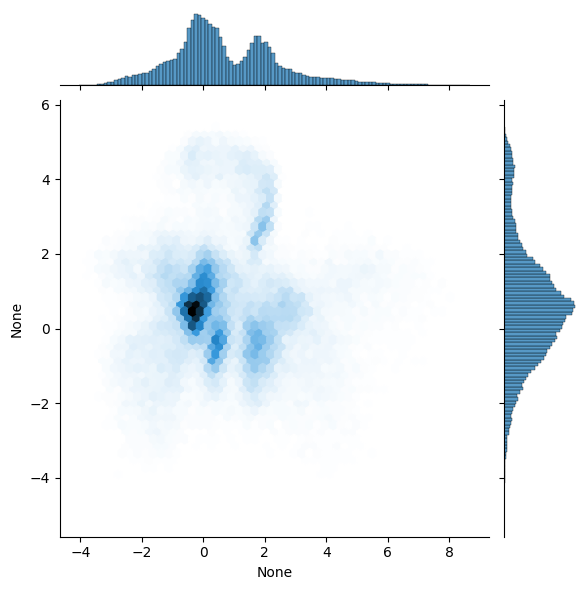

In [75]:
sns.jointplot(x=all_coords[:,0], y=all_coords[:,1], kind='hex')
plt.show()

Lets generate then some new images.

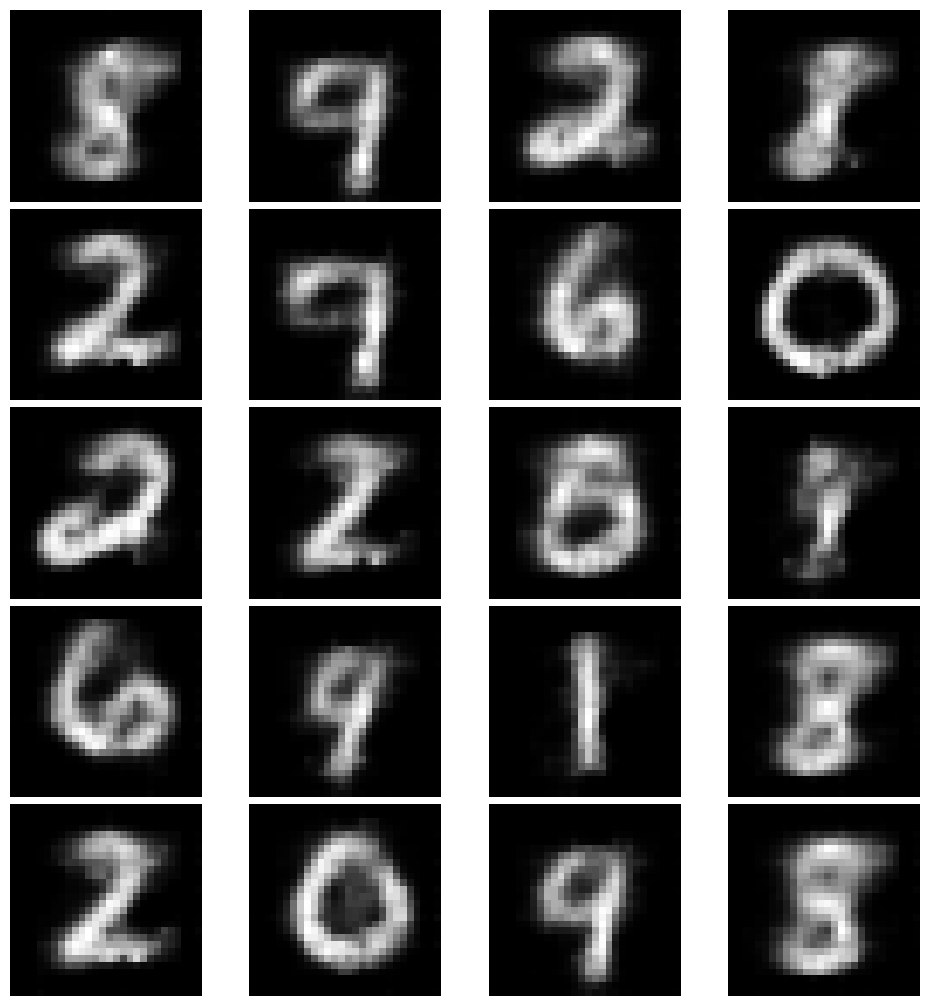

In [48]:
cnt = 20
encoded_fake = torch.normal(
    mean=torch.tensor([0.7354, 0.5829]).unsqueeze(0).repeat(cnt, 1), 
    std=torch.tensor([1.7769, 1.5603]).unsqueeze(0).repeat(cnt, 1))

with torch.no_grad():
    decoded = model.decoder(encoded_fake)
images = [(to_image(r)) for r in decoded]
plot_images(images, 4)

We can also interpolate between two base vectors, and see respective generated images

tensor([[-0.3649,  0.2061],
        [-0.7873,  1.0175]])


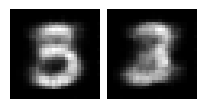

In [49]:
all_ids = torch.where(all_digits == 7)[0]
idx1 = 0
idx2 = 5
with torch.no_grad():
    decoded = model.decoder(all_coords[[idx1, idx2], :])

images = [to_image(r) for r in decoded]
print(all_coords[[idx1, idx2], :])
plot_images(images, 2, figsize=(2,2))

In [50]:
interpolated = interpolate_vectors(all_coords[idx1], all_coords[idx2], 30)

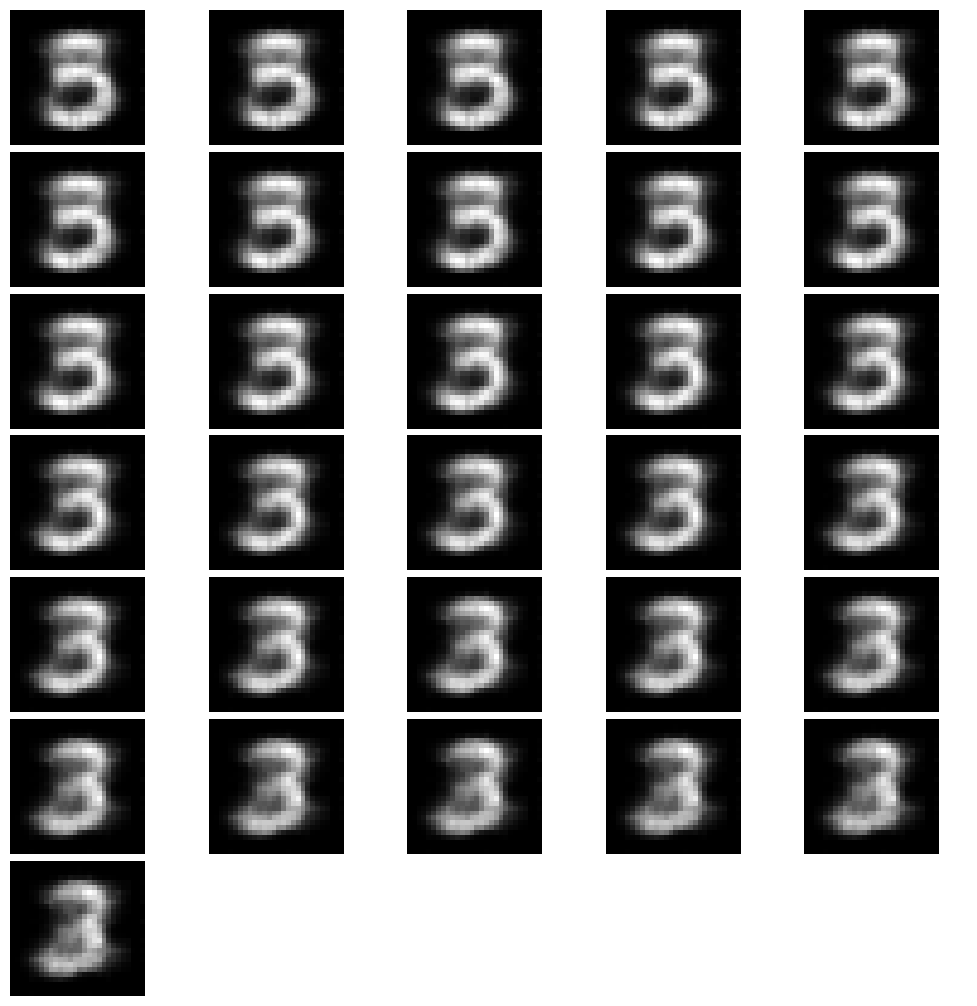

In [51]:
with torch.no_grad():
    decoded = model.decoder(interpolated)
images = [to_image(r) for r in decoded]
plot_images(images, 5)

Although the results are not totally wrong, for the general case we find two problems:
- Autoencoder are trained to fit well for training data. No guaratee of correct image generation for a different latent vector
- Unknown distribution of latent space, so generating new ones can be totally wrong.

## Variational Autoencoders (VAEs)

To improve the quality of the results, we switch from a latent vector to a latent **distribution**. We also:
- Encourage latent space continuity, via KL divergence in loss
- Easy sampling from latent space: decoding random samples from distribution.

<img src="images/VAEs.png" alt="GAN network" width="600" height="400">

In [52]:
import torch.nn.functional as F

class VAEEncoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)  # 14x14 -> 7x7
        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(32 * 7 * 7, latent_dim)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar


In [53]:
encoder = VAEEncoder()
x = torch.rand((128, 1, 28, 28))
mu, logvar = encoder(x)
mu.shape, logvar.shape

(torch.Size([128, 16]), torch.Size([128, 16]))

In [54]:
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 32 * 7 * 7)
        self.conv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)  # 7x7 -> 14x14
        self.conv1 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)  # 14x14 -> 28x28

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 32, 7, 7)
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv1(x))
        x = torch.sigmoid(x)
        return x        

In [55]:
x = torch.rand((128,16))
decoder = VAEDecoder(16)
dec = decoder(x)
dec.shape

torch.Size([128, 1, 28, 28])

In [56]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.encoder = VAEEncoder(latent_dim)
        self.decoder = VAEDecoder(latent_dim)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    # Reparametrization trick
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

<img src="images/reparam_trick.png" alt="GAN network" width="400" height="300">

In [57]:
vae = VariationalAutoencoder(16)
x = torch.rand((128, 1, 28, 28))
imgs, mu, logvar = vae(x)
imgs.shape, mu.shape, logvar.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 16]), torch.Size([128, 16]))

In [58]:
class VAELoss(nn.Module):
    def __init__(self, variational_beta=1):
        super().__init__()
        self.variational_beta = variational_beta

    def forward(self, recon_x, x, mu, logvar):
        # recon_x is the probability of a multivariate Bernoulli distribution p.
        # -log(p(x)) is then the pixel-wise binary cross-entropy.
        # Averaging or not averaging the binary cross-entropy over all pixels here
        # is a subtle detail with big effect on training, since it changes the weight
        # we need to pick for the other loss term by several orders of magnitude.
        # Not averaging is the direct implementation of the negative log likelihood,
        # but averaging makes the weight of the other loss term independent of the image resolution.
        recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum') 

        # KL-divergence between the prior distribution over latent vectors
        # (the one we are going to sample from when generating new images)
        # and the distribution estimated by the generator for the given image.
        kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return recon_loss + self.variational_beta * kldivergence

In [59]:
vae = VariationalAutoencoder(16)
loss = VAELoss()
x = torch.rand((128, 1, 28, 28))
imgs, mu, logvar = vae(x)
loss(x, imgs, mu, logvar)

tensor(100295.1250, grad_fn=<AddBackward0>)

In [60]:
# Model, loss, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

latent_dim = 16
model = VariationalAutoencoder(latent_dim=latent_dim).to(device)
criterion = VAELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

cuda:0


In [61]:
import time

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    if get_gpu_temperature() >= 80:
        time.sleep(30)
    for images, _ in dataloader:
        images_dev = images.to(device)
        optimizer.zero_grad()

        imgs, mu, logvar = model(images_dev)
        loss = criterion(imgs, images_dev, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(dataloader):.4f}")

# Save the model
# torch.save(model.state_dict(), f'models/vae_{latent_dim}.pth')

KeyboardInterrupt: 

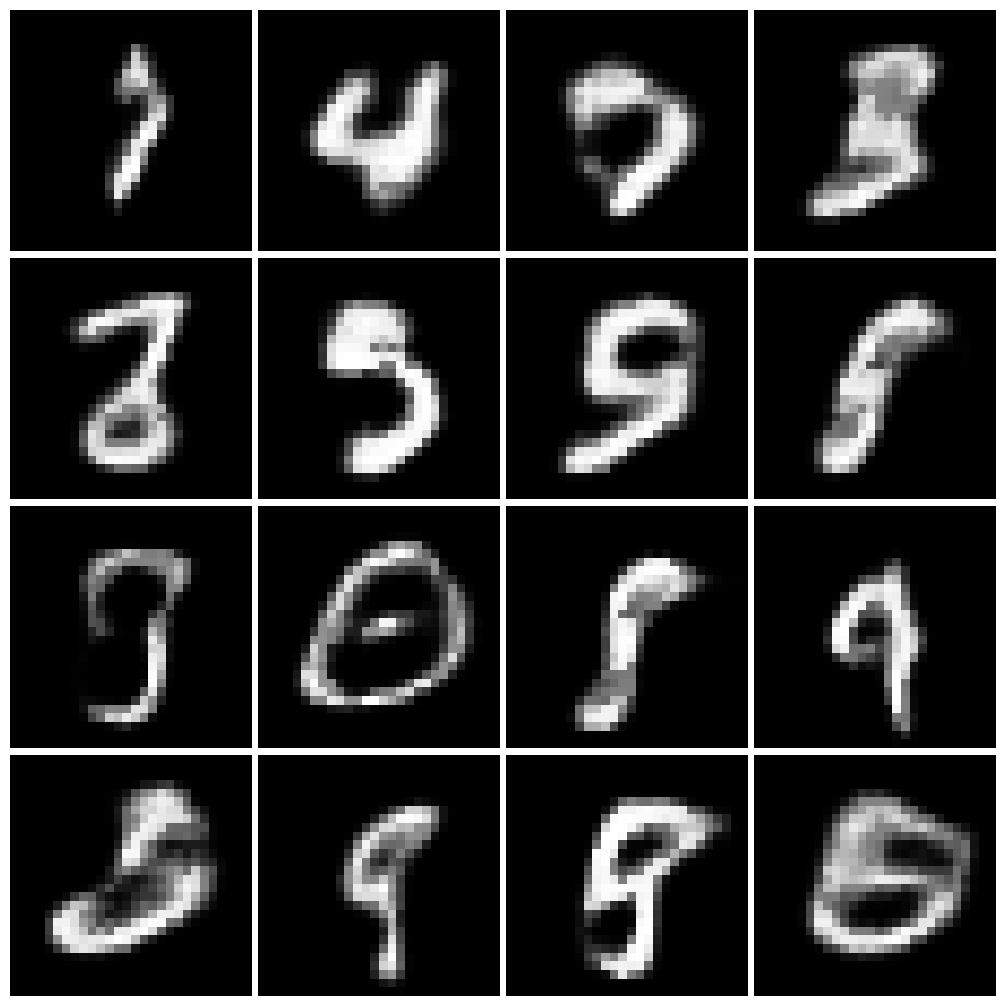

In [84]:
latent_dim = 16
model = VariationalAutoencoder(latent_dim).to(device)
model.load_state_dict(torch.load(f'models/vae_{latent_dim}.pth'))


model.eval()
latent = torch.randn(16, latent_dim).to(device)
with torch.no_grad():
    # reconstruct images from the latent vectors
    img_recon = model.decoder(latent)

images = [to_image(r) for r in img_recon]
plot_images(images, 4)
# fig, ax = plt.subplots(figsize=(5, 5))
# show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
# plt.show()

In [77]:
latent_dim = 2
model = VariationalAutoencoder(latent_dim).to(device)
model.load_state_dict(torch.load(f'models/vae_{latent_dim}.pth'))

coords = []
digits = []
model.eval
for image, digit in dataloader:
    with torch.no_grad():
        coord, _ = model.encoder(image.to(device))
        coords.append(coord)
    digits.append(digit)

In [78]:
all_coords = torch.cat(coords, dim=0).cpu()
all_digits = torch.cat(digits, dim=0).cpu()

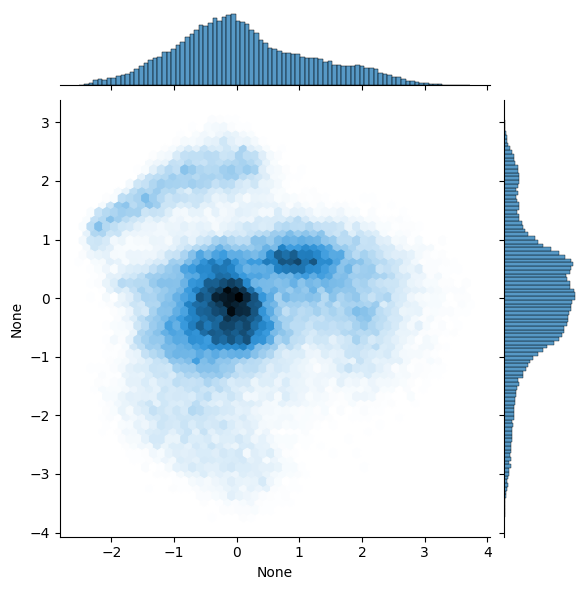

In [79]:
sns.jointplot(x=all_coords[:,0], y=all_coords[:,1], kind='hex')
plt.show()

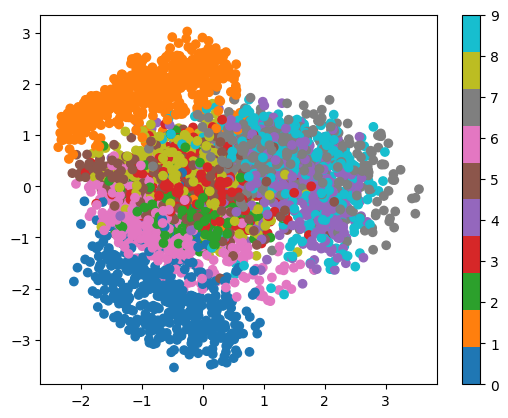

In [82]:
all_coords.shape, all_digits.shape
scatter = plt.scatter(all_coords[:5000,0], all_coords[:5000, 1], c=all_digits[:5000], 
                      cmap='tab10')
plt.colorbar(scatter)
plt.show()